<a href="https://colab.research.google.com/github/HONG-JU-OH/Bitcoin-Prediction-Project/blob/main/GRU%20%EB%AA%A8%EB%8D%B8_%20%EC%95%A0%EB%8B%88%EB%A9%94%EC%9D%B4%EC%85%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. GRU 모델을 이용한 슬라이싱 기법적용 (21년 1월 ~ 21년 8월 데이터 )

In [ ]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install workalendar # 공휴일 데이터 추가를 위한 달력 패키지

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.2 MB/s eta 0:00:00


## 1. 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 데이터 불러오기
start_date = '2021-01-01'
end_date = '2021-08-31'
bitcoin_df = fdr.DataReader('BTC/KRW', start_date, end_date) #FinanceDataReader 에서 DataReader 함수 불러온다 , 'BTC/KRW' : 비트코인을 나타낸다.
bitcoin_df = bitcoin_df[['Close']]
bitcoin_df = bitcoin_df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})  # reset_index(): 설정 인덱스를 제거하고 기본 인덱스로 변경하는 메서드
bitcoin_df.to_csv("btc_price.csv", index=False)

In [ ]:
bitcoin_df.head()

,ds,y
0,2021-01-01,31892398.0
1,2021-01-02,34881540.0
2,2021-01-03,35641816.0
3,2021-01-04,34743756.0
4,2021-01-05,36965032.0


## 2. 데이터 전처리

In [ ]:
# 데이터 전처리
scaler = MinMaxScaler()  #M MinMaxScaler 는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과1 사이의 값을 갖도록 해주는 함수이다
                         # 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해줍니다.
                        # 정규화를 하는 목적은 데이터 범위의 숫자 열값을 변경하여, 값 범위의 차이를 수정하지 않고 공통척도를 사용하는 것이다

bitcoin_scaled = scaler.fit_transform(bitcoin_df[['y']])  # fit_transform() :fit()과 transform()을 한번에 처리할 수 있게 하는 메서드
                                                          # fit_transform() : train dataset에서만 사용
                                                          # scler : 학습이 느리거나 문제가 발생하는 경우가 종종 발생하게되면 Scaler를 이용하여 동일하게 일정 범위로 스케일링하는 것이 필요하다

In [ ]:
scaler

MinMaxScaler()

In [ ]:
bitcoin_scaled

array([[0.        ],
       [0.07598477],
       [0.09531119],
       [0.07248227],
       [0.12894768],
       [0.20770057],
       [0.2842665 ],
       [0.32283219],
       [0.30774333],
       [0.25500483],
       [0.18150652],
       [0.13247805],
       [0.23092594],
       [0.28097966],
       [0.22299625],
       [0.20483632],
       [0.1938871 ],
       [0.21737461],
       [0.19997983],
       [0.18093385],
       [0.05124242],
       [0.11685171],
       [0.09048754],
       [0.09677102],
       [0.09655373],
       [0.1017778 ],
       [0.04681787],
       [0.13633725],
       [0.16492864],
       [0.16359692],
       [0.13077062],
       [0.14189026],
       [0.19505429],
       [0.25008621],
       [0.24075555],
       [0.27310009],
       [0.30497161],
       [0.29484997],
       [0.501456  ],
       [0.50200213],
       [0.45323712],
       [0.53285185],
       [0.52290836],
       [0.51169772],
       [0.55694894],
       [0.53278016],
       [0.57436009],
       [0.655

## 3. 입력데이터와 타켓 데이터 생성

In [ ]:
# 입력 데이터와 타겟 데이터 생성
window_size = 15   # windw_size : 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 parameter(파라미터) 이다. 15일을 기반으로 내일데이터를 예측한다.
slide_step = 1    # 1만큼 전진하면서 그래프로 보여준다.

X = []
y = []
for i in range(len(bitcoin_scaled) - window_size):   # 위에서 정의내린 bitcoin_scaled의 길이- window_size 만큼 범위로 잡았다.
    X.append(bitcoin_scaled[i:i+window_size])        # append() : 괄호( )안에 값을 입력하면 새로운 요소를 array 맨 끝에 객체로 추가한다. bitcoin_scaled 에서 i부터 i+ window_size 까지 추가를 한다.
    y.append(bitcoin_scaled[i+window_size])          # append() : 괄호( )안에 값을 입력하면 새로운 요소를 array 맨 끝에 객체로 추가한다. bitcoin_scaled 에서 i+ window_size 까지 추가를 한다.

X = np.array(X)  # 넘파이의 array 함수에 X값을 입력값으로 갖고, X라는 변수로 지칭한다.
y = np.array(y)

In [ ]:
X

array([[[0.        ],
        [0.07598477],
        [0.09531119],
        ...,
        [0.23092594],
        [0.28097966],
        [0.22299625]],

       [[0.07598477],
        [0.09531119],
        [0.07248227],
        ...,
        [0.28097966],
        [0.22299625],
        [0.20483632]],

       [[0.09531119],
        [0.07248227],
        [0.12894768],
        ...,
        [0.22299625],
        [0.20483632],
        [0.1938871 ]],

       ...,

       [[0.58090763],
        [0.5794356 ],
        [0.55337159],
        ...,
        [0.58662313],
        [0.63881031],
        [0.63419308]],

       [[0.5794356 ],
        [0.55337159],
        [0.52706752],
        ...,
        [0.63881031],
        [0.63419308],
        [0.63205015]],

       [[0.55337159],
        [0.52706752],
        [0.52252512],
        ...,
        [0.63419308],
        [0.63205015],
        [0.58460791]]])

In [ ]:
y

array([[0.20483632],
       [0.1938871 ],
       [0.21737461],
       [0.19997983],
       [0.18093385],
       [0.05124242],
       [0.11685171],
       [0.09048754],
       [0.09677102],
       [0.09655373],
       [0.1017778 ],
       [0.04681787],
       [0.13633725],
       [0.16492864],
       [0.16359692],
       [0.13077062],
       [0.14189026],
       [0.19505429],
       [0.25008621],
       [0.24075555],
       [0.27310009],
       [0.30497161],
       [0.29484997],
       [0.501456  ],
       [0.50200213],
       [0.45323712],
       [0.53285185],
       [0.52290836],
       [0.51169772],
       [0.55694894],
       [0.53278016],
       [0.57436009],
       [0.65557731],
       [0.64384149],
       [0.76062797],
       [0.76657123],
       [0.80653991],
       [0.72249076],
       [0.56725024],
       [0.58838546],
       [0.52960263],
       [0.51434864],
       [0.51002212],
       [0.47999509],
       [0.58026837],
       [0.57321028],
       [0.63881397],
       [0.589

## 4. 모델 생성

In [ ]:
# 모델 생성
model = Sequential()   # 모델의 객체생성
model.add(GRU(64, input_shape=(window_size, 1)))   # 64: 레이어의 출력차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                   # window_size: 이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인것을 의미한다

model.add(Dense(1))      # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model.compile(loss='mean_squared_error', optimizer='adam')   # compile() 함수를 이용하여 모델을 컴파일합니다
                                                           # loss는 손실 함수를 의미한다.
                                                   # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                   # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다
                                                  # 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
                                                  # AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model

## 5. 애니메이션 설정 및 저장

<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 443ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 9ms/step - loss: 0.0059


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0033

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0030

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 6.5402e-05

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0021


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0096


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 40ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0061


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 46ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0094


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 35ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0126


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0067


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 52ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 33ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 32ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0154


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0238


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 10ms/step - loss: 4.1869e-04


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 10ms/step - loss: 1.4968e-04


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 10ms/step - loss: 0.0046


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 10ms/step - loss: 0.0046


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 11ms/step - loss: 5.5793e-04


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 1.1342e-04

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 9ms/step - loss: 6.4498e-05


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0337

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0011

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 32ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 32ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0215

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 47ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - ETA: 0s

<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 35ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 20ms/step - loss: 0.0214


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 46ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0467


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 43ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 33ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0243


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 41ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0173


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 31ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 3.5981e-05

<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 29ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 32ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0168


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0119


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 41ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0043


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0426


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0168


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 43ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0192


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 57ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 4.5938e-04


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0214


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 56ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 31ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 29ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 31ms/step


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 8.7746e-05


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 49ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0129


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0182


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 45ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 26ms/step - loss: 0.0042


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 31ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 32ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 41ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 8.6119e-04


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 54ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0058


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 4.8982e-06


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 3.6179e-05


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 40ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0014


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0023


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 45ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0047


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0132


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0253


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 35ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0216


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 45ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 29ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0021


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 60ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0075


<ipython-input-7-53af35328c47>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-7-53af35328c47>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


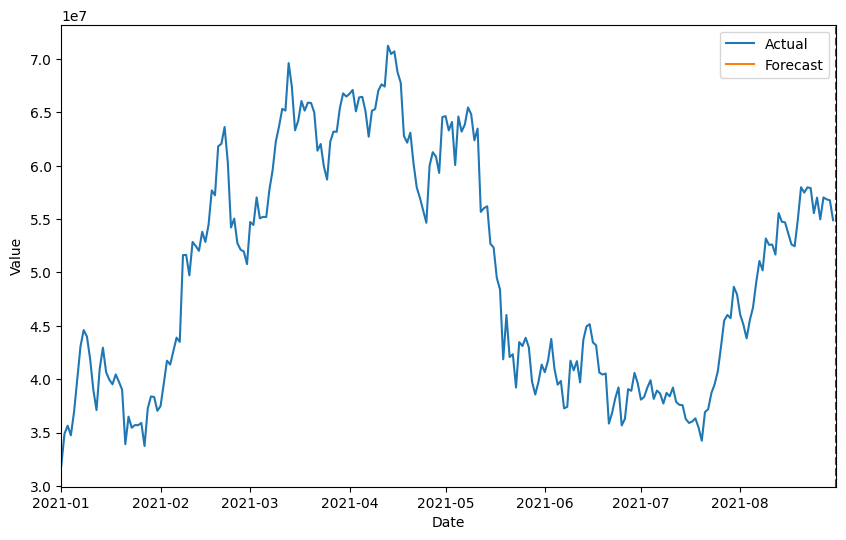

In [ ]:
# 애니메이션 설정
fig, ax = plt.subplots(figsize=(10, 6))  #  plt.figure 메소드에 figsize 옵션을 설정한다, figsize=(가로길이, 세로길이)
                                          # fig : 데이터가 담기는 프레임 (크기, 모양을 변형할수 있지만 실제로 프레임 위에 글씨를 쓸수없다)
                                          # ax : 실제 데이터가 그려지는 캔버스 ,모든 plot은 이 ax 위애서 이루어져야 하는 것이다.

line_actual, = ax.plot([], [], label='Actual')  # ax는 그래프를 그릴 축(Axes) 객체를 나타냅니다.
                                                  # 쉼표(,)는 Python의 언패킹 기능을 나타냅니다. 이를 통해 ax.plot([], []) 함수의 반환값을 여러 변수에 동시에 할당할 수 있다.
                                                  # 언패킹 : 여러개의 객체를 포함하고 있는 하나의 객체를 풀어준다.    <---->  패킹 : 여러개의 객체를 하나의 객체로 합쳐준다.
                                                  # [ ] : 실제 데이터가 입력되기 전에 그래프를 초기화하는 용도이다.

line_forecast, = ax.plot([], [], label='Forecast')
line_vertical = ax.axvline(0, color='red', linestyle='--')  # axvline() : 세로선을 그릴수있다. axvline(x좌표=0 , color= 빨간색, linestyle= --)




def init():
    ax.set_xlabel('Date')  # 그래프 x축을 Date 로 지정
    ax.set_ylabel('Value')  # 그래프 y축을 Value로 지정
    ax.legend()  # 그래프의 범례출력
    return line_actual, line_forecast, line_vertical

def update(frame):
    start_idx = frame
    end_idx = frame + window_size

    ax.set_xlim(bitcoin_df['ds'][0], bitcoin_df['ds'][len(bitcoin_df) - 1])  # ax 객체에 x 축의 범위를 설정, (ds 열에서 첫 번째 행의 값, ds 열에서 마지막 행의 값)을 가져오는 것을 말한다.

    line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
                                                        # 따라서 line_vertical의 x 데이터를 bitcoin_df['y'][end_idx]로 변경하는 것이다.
    line_vertical.set_visible(True)  # 세로선을 표시하도록 설정

    current_data = bitcoin_df.iloc[start_idx:end_idx]  # bitcoin_df에서 특정 범위의 행을 추출하여 current_data라는 새로운 데이터프레임을 생성한다.
                                                        # iloc : 행과 열을 정수 인덱스를 사용하여 선택하기 위한 메서드이다.
                                                        # iloc[start_idx:end_idx] : start_idx부터 end_idx 이전까지의 행을 선택하는 것을 의미합니다.

    current_scaled = bitcoin_scaled[start_idx:end_idx] # bitcoin_scaled 배열에서 start_idx부터 end_idx 이전까지의 값들을 추출하여 current_scaled라는 새로운 배열을 생성한다.

    # 모델 학습
    model.fit(np.expand_dims(current_scaled, axis=0), np.expand_dims(y[frame], axis=0), epochs=1, batch_size=1)
             # np.expand_dims(current_sclaed, axis=0) : 입력 데이터인 current_scaled의 차원을 확장하여 모델에 맞는 형태로 변환하는 역할을 하고, axis=0은 새로운 차원을 첫 번째 축에 추가한다.
             # np.expand_dims(y[frame], axis=0) :  y[frame]의 차원을 확장하여 모델에 맞는 형태로 변환하고, axis=0은 새로운 차원을 첫번째 축에 추가한다.
             # epochs=1 : 반복횟수가 1번이다.
             # batch_size : 한 번의 반복마다 사용할 샘플의 개수를 지정하는 매개변수 ,학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다


    # 예측
    future = np.array([current_scaled[-window_size:]])  # current_scaled에서 마지막 window_size 개의 값을 추출하여 future라는 새로운 배열을 생성한다
    predicted = model.predict(future)  # 입력 데이터 future에 대한 모델의 예측 값을 계산하여 predicted 변수에 할당한다.
    predicted = scaler.inverse_transform(predicted)  #  예측된 값을 원래의 스케일로 변환하여 predicted 변수에 할당한다
                                                    # scaler.inverse_transform() : 스케일된 데이터를 원래의 스케일로 되돌리는 역변환을 수행하는 메서드이다

    line_actual.set_data(bitcoin_df['ds'][:end_idx], bitcoin_df['y'][:end_idx])  # line_actual의 데이터를 bitcoin_df의 ds와 y열에서 선택한 데이터로 설정하여 그래프의 선을 새로운 데이터로 업데이트하는 것이다
    line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


    ax.relim()  # 그래프의 데이터 제한을 재계산하여 그래프를 새로 그리지 않고도 최신의 데이터에 맞게 업데이트하는 역할을 한다
    ax.autoscale_view()   # 그래프의 축 범위가 데이터에 따라 자동으로 조정

    return line_actual, line_forecast, line_vertical

def update_vertical(frame):  # line_vertical을 업데이트하는 함수 ,가상의 선을 그려주는 함수
    start_idx = frame
    end_idx = frame + window_size

    line_vertical.set_xdata(bitcoin_df['ds'][end_idx])
    line_vertical.set_visible(True)

    return line_vertical,

ani = FuncAnimation(fig, update, frames=range(len(bitcoin_df) - window_size),
                    init_func=init, blit=True)

# 애니메이션 저장
ani.save('bitcoin_animation.mp4', writer='ffmpeg')

# 애니메이션 표시
plt.show()

# 2. GRU 모델을 이용한 슬라이싱 기법적용 (22년 1월 ~ 22년 8월 데이터 )

In [ ]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install workalendar # 공휴일 데이터 추가를 위한 달력 패키지

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.9 MB/s eta 0:00:00


## 1. 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 데이터 불러오기
start_date = '2022-01-01'
end_date = '2022-08-31'
bitcoin_df = fdr.DataReader('BTC/KRW', start_date, end_date) #FinanceDataReader 에서 DataReader 함수 불러온다 , 'BTC/KRW' : 비트코인을 나타낸다.
bitcoin_df = bitcoin_df[['Close']]
bitcoin_df = bitcoin_df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})  # reset_index(): 설정 인덱스를 제거하고 기본 인덱스로 변경하는 메서드
bitcoin_df.to_csv("btc_price.csv", index=False)

In [ ]:
bitcoin_df.head()

,ds,y
0,2022-01-01,56693896.0
1,2022-01-02,56288032.0
2,2022-01-03,55549032.0
3,2022-01-04,54962304.0
4,2022-01-05,52293708.0


## 2. 데이터 전처리

In [ ]:
# 데이터 전처리
scaler = MinMaxScaler()  #M MinMaxScaler 는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과1 사이의 값을 갖도록 해주는 함수이다
                         # 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해줍니다.
                        # 정규화를 하는 목적은 데이터 범위의 숫자 열값을 변경하여, 값 범위의 차이를 수정하지 않고 공통척도를 사용하는 것이다

bitcoin_scaled = scaler.fit_transform(bitcoin_df[['y']])  # fit_transform() :fit()과 transform()을 한번에 처리할 수 있게 하는 메서드
                                                          # fit_transform() : train dataset에서만 사용
                                                          # scler : 학습이 느리거나 문제가 발생하는 경우가 종종 발생하게되면 Scaler를 이용하여 동일하게 일정 범위로 스케일링하는 것이 필요하다

In [ ]:
scaler

MinMaxScaler()

## 3. 입력 데이터와 타겟 데이터 생성

In [ ]:
# 입력 데이터와 타겟 데이터 생성
window_size = 15   # windw_size : 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 parameter(파라미터) 이다. 15일을 기반으로 내일데이터를 예측한다.
slide_step = 1    # 1만큼 전진하면서 그래프로 보여준다.

X = []
y = []
for i in range(len(bitcoin_scaled) - window_size):   # 위에서 정의내린 bitcoin_scaled의 길이- window_size 만큼 범위로 잡았다.
    X.append(bitcoin_scaled[i:i+window_size])        # append() : 괄호( )안에 값을 입력하면 새로운 요소를 array 맨 끝에 객체로 추가한다. bitcoin_scaled_b 에서 i부터 i+ window_size 까지 추가를 한다.
    y.append(bitcoin_scaled[i+window_size])          # append() : 괄호( )안에 값을 입력하면 새로운 요소를 array 맨 끝에 객체로 추가한다. bitcoin_scaled_b 에서 i+ window_size 까지 추가를 한다.

X = np.array(X)  # 넘파이의 array 함수에 X값을 입력값으로 갖고, X라는 변수로 지칭한다.
y = np.array(y)

In [ ]:
X

array([[[0.        ],
        [0.07598477],
        [0.09531119],
        ...,
        [0.23092594],
        [0.28097966],
        [0.22299625]],

       [[0.07598477],
        [0.09531119],
        [0.07248227],
        ...,
        [0.28097966],
        [0.22299625],
        [0.20483632]],

       [[0.09531119],
        [0.07248227],
        [0.12894768],
        ...,
        [0.22299625],
        [0.20483632],
        [0.1938871 ]],

       ...,

       [[0.58090763],
        [0.5794356 ],
        [0.55337159],
        ...,
        [0.58662313],
        [0.63881031],
        [0.63419308]],

       [[0.5794356 ],
        [0.55337159],
        [0.52706752],
        ...,
        [0.63881031],
        [0.63419308],
        [0.63205015]],

       [[0.55337159],
        [0.52706752],
        [0.52252512],
        ...,
        [0.63419308],
        [0.63205015],
        [0.58460791]]])

In [ ]:
y

array([[0.20483632],
       [0.1938871 ],
       [0.21737461],
       [0.19997983],
       [0.18093385],
       [0.05124242],
       [0.11685171],
       [0.09048754],
       [0.09677102],
       [0.09655373],
       [0.1017778 ],
       [0.04681787],
       [0.13633725],
       [0.16492864],
       [0.16359692],
       [0.13077062],
       [0.14189026],
       [0.19505429],
       [0.25008621],
       [0.24075555],
       [0.27310009],
       [0.30497161],
       [0.29484997],
       [0.501456  ],
       [0.50200213],
       [0.45323712],
       [0.53285185],
       [0.52290836],
       [0.51169772],
       [0.55694894],
       [0.53278016],
       [0.57436009],
       [0.65557731],
       [0.64384149],
       [0.76062797],
       [0.76657123],
       [0.80653991],
       [0.72249076],
       [0.56725024],
       [0.58838546],
       [0.52960263],
       [0.51434864],
       [0.51002212],
       [0.47999509],
       [0.58026837],
       [0.57321028],
       [0.63881397],
       [0.589

## 4. 모델생성

In [ ]:
# 모델 생성
model = Sequential()   # 모델의 객체생성
model.add(GRU(64, input_shape=(window_size, 1)))   # 64: 레이어의 출력차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                   # window_size: 이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인것을 의미한다

model.add(Dense(1))      # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model.compile(loss='mean_squared_error', optimizer='adam')   # compile() 함수를 이용하여 모델을 컴파일합니다
                                                           # loss는 손실 함수를 의미한다.
                                                   # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                   # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다
                                                  # 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
                                                  # AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.

In [ ]:
model

## 5. 애니메이션 설정 및 저장

<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 394ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 12ms/step - loss: 0.1835


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 31ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 40ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0220


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0081


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 43ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 35ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0035


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 46ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 12ms/step - loss: 8.8399e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 52ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 4.5961e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 52ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0019


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 45ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 2.3514e-04

<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 7.5502e-07

<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 7.6517e-04

<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0099

<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 29ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 1.6058e-08


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0016


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0011


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 43ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 1.9286e-05


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0098


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 1.9311e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0072


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 54ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 11ms/step - loss: 0.0041


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 29ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 42ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0073


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0042


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 21ms/step - loss: 0.0144


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 22ms/step - loss: 0.0135


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 45ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 0.0061


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 43ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 34ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 3.6412e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 41ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 1.2607e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 21ms/step - loss: 0.0024


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 47ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 32ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 30ms/step - loss: 0.0020


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 8.8300e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 47ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0029


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 51ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0150


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 41ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0130


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 7.4629e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 47ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0021


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 49ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 6.4192e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 38ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step - loss: 6.3610e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - ETA: 0s - loss: 0.0063

<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 30ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 26ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0040


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 44ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0034


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 35ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0023


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 3.3552e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 36ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 4.6619e-06


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 47ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 5.2338e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0020


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0028


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 40ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 13ms/step - loss: 0.0039


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 49ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 28ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 32ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 25ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 33ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 22ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 39ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다
<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 37ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 18ms/step - loss: 5.0785e-04


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 43ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - ETA: 0s

<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 40ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 14ms/step - loss: 0.0107


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 49ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 19ms/step - loss: 0.0057


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 40ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0025


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 48ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0022


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 51ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 16ms/step - loss: 0.0017


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 56ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 17ms/step - loss: 0.0019


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 45ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 15ms/step - loss: 0.0013


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.


1/1 [==============================] - 0s 46ms/step


<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 28ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 27ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 24ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


1/1 [==============================] - 0s 23ms/step


<ipython-input-12-62fb44db4d1e>:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
<ipython-input-12-62fb44db4d1e>:54: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


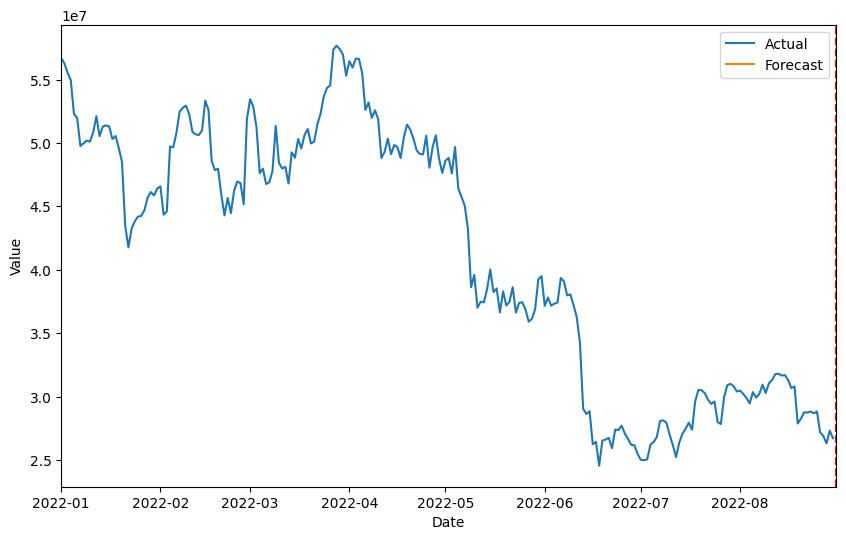

In [ ]:
# 애니메이션 설정
fig, ax = plt.subplots(figsize=(10, 6))  #  plt.figure 메소드에 figsize 옵션을 설정한다, figsize=(가로길이, 세로길이)
                                          # fig : 데이터가 담기는 프레임 (크기, 모양을 변형할수 있지만 실제로 프레임 위에 글씨를 쓸수없다)
                                          # ax : 실제 데이터가 그려지는 캔버스 ,모든 plot은 이 ax 위애서 이루어져야 하는 것이다.

line_actual, = ax.plot([], [], label='Actual')  # ax는 그래프를 그릴 축(Axes) 객체를 나타냅니다.
                                                  # 쉼표(,)는 Python의 언패킹 기능을 나타냅니다. 이를 통해 ax.plot([], []) 함수의 반환값을 여러 변수에 동시에 할당할 수 있다.
                                                  # 언패킹 : 여러개의 객체를 포함하고 있는 하나의 객체를 풀어준다.    <---->  패킹 : 여러개의 객체를 하나의 객체로 합쳐준다.
                                                  # [ ] : 실제 데이터가 입력되기 전에 그래프를 초기화하는 용도이다.

line_forecast, = ax.plot([], [], label='Forecast')
line_vertical = ax.axvline(0, color='red', linestyle='--')  # axvline() : 세로선을 그릴수있다. axvline(x좌표=0 , color= 빨간색, linestyle= --)




def init():
    ax.set_xlabel('Date')  # 그래프 x축을 Date 로 지정
    ax.set_ylabel('Value')  # 그래프 y축을 Value로 지정
    ax.legend()  # 그래프의 범례출력
    return line_actual, line_forecast, line_vertical

def update(frame):
    start_idx = frame
    end_idx = frame + window_size

    ax.set_xlim(bitcoin_df['ds'][0], bitcoin_df['ds'][len(bitcoin_df) - 1])  # ax 객체에 x 축의 범위를 설정, (ds 열에서 첫 번째 행의 값, ds 열에서 마지막 행의 값)을 가져오는 것을 말한다.

    line_vertical.set_xdata(bitcoin_df['ds'][end_idx])  #line_vertical의 x 데이터를 변경한다. bitcoin_df의 y 열에서 end_idx에 해당하는 행의 값을 가져오는것이다.
                                                        # 따라서 line_vertical의 x 데이터를 bitcoin_df['y'][end_idx]로 변경하는 것이다.
    line_vertical.set_visible(True)  # 세로선을 표시하도록 설정

    current_data = bitcoin_df.iloc[start_idx:end_idx]  # bitcoin_df에서 특정 범위의 행을 추출하여 current_data라는 새로운 데이터프레임을 생성한다.
                                                        # iloc : 행과 열을 정수 인덱스를 사용하여 선택하기 위한 메서드이다.
                                                        # iloc[start_idx:end_idx] : start_idx부터 end_idx 이전까지의 행을 선택하는 것을 의미합니다.

    current_scaled = bitcoin_scaled[start_idx:end_idx] # bitcoin_scaled 배열에서 start_idx부터 end_idx 이전까지의 값들을 추출하여 current_scaled라는 새로운 배열을 생성한다.

    # 모델 학습
    model.fit(np.expand_dims(current_scaled, axis=0), np.expand_dims(y[frame], axis=0), epochs=1, batch_size=1)
             # np.expand_dims(current_sclaed, axis=0) : 입력 데이터인 current_scaled의 차원을 확장하여 모델에 맞는 형태로 변환하는 역할을 하고, axis=0은 새로운 차원을 첫 번째 축에 추가한다.
             # np.expand_dims(y[frame], axis=0) :  y[frame]의 차원을 확장하여 모델에 맞는 형태로 변환하고, axis=0은 새로운 차원을 첫번째 축에 추가한다.
             # epochs=1 : 반복횟수가 1번이다.
             # batch_size : 한 번의 반복마다 사용할 샘플의 개수를 지정하는 매개변수 ,학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다


    # 예측
    future = np.array([current_scaled[-window_size:]])  # current_scaled에서 마지막 window_size 개의 값을 추출하여 future라는 새로운 배열을 생성한다
    predicted = model.predict(future)  # 입력 데이터 future에 대한 모델의 예측 값을 계산하여 predicted 변수에 할당한다.
    predicted = scaler.inverse_transform(predicted)  #  예측된 값을 원래의 스케일로 변환하여 predicted 변수에 할당한다
                                                    # scaler.inverse_transform() : 스케일된 데이터를 원래의 스케일로 되돌리는 역변환을 수행하는 메서드이다

    line_actual.set_data(bitcoin_df['ds'][:end_idx], bitcoin_df['y'][:end_idx])  # line_actual의 데이터를 bitcoin_df의 ds와 y열에서 선택한 데이터로 설정하여 그래프의 선을 새로운 데이터로 업데이트하는 것이다
    line_forecast.set_data(bitcoin_df['ds'][end_idx], predicted[0][0])  # line_forecast의 데이터를 bitcoin_df의 ds열에서 선택한 데이터와 predicted의 예측값으로 설정하여 그래프의 예측 선을 새로운 데이터로 업데이트 하는 것이다


    ax.relim()  # 그래프의 데이터 제한을 재계산하여 그래프를 새로 그리지 않고도 최신의 데이터에 맞게 업데이트하는 역할을 한다
    ax.autoscale_view()   # 그래프의 축 범위가 데이터에 따라 자동으로 조정

    return line_actual, line_forecast, line_vertical

def update_vertical(frame):  # line_vertical을 업데이트하는 함수
    start_idx = frame
    end_idx = frame + window_size

    line_vertical.set_xdata(bitcoin_df['ds'][end_idx])
    line_vertical.set_visible(True)

    return line_vertical,

ani = FuncAnimation(fig, update, frames=range(len(bitcoin_df) - window_size),
                    init_func=init, blit=True)

# 애니메이션 저장
ani.save('bitcoin_animation_b.mp4', writer='ffmpeg')

# 애니메이션 표시
plt.show()